# Gaussian Process

In [4]:
using Optim
using PyPlot
using Latexify
using Distributions
using LinearAlgebra
using Random

include("../src/gaussianprocess.jl")

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1278


logmarginalgradient

## Effect of hyperparameters

In [5]:
# Thetas = [
#     [sqrt(1/4.0),  1.0, 0.0,  0.0],
#     [sqrt(1/4.0),  9.0, 0.0,  0.0],
#     [sqrt(1/64.0), 1.0, 0.0,  0.0],
#     [sqrt(1/0.25), 1.0, 0.0,  0.0],
#     [sqrt(1/4.0),  1.0, 10.0, 0.0],
#     [sqrt(1/4.0),  1.0, 0.0,  5.0]
# ]

# length scale (l), vertical scale (σf), observation noise (σy), θ0, θ1
Thetas = [
    [0.5, 1.0, 0.0, 0.0, 0.0],
    [0.5, 3.0, 0.0, 0.0, 0.0],
    [0.125, 1.0, 0.0, 0.0, 0.0],
    [2.0, 1.0, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.0, 10.0, 0.0],
    [0.5, 1.0, 0.0, 0.0, 5.0]
]

x = collect(range(-1, 1, length=101));

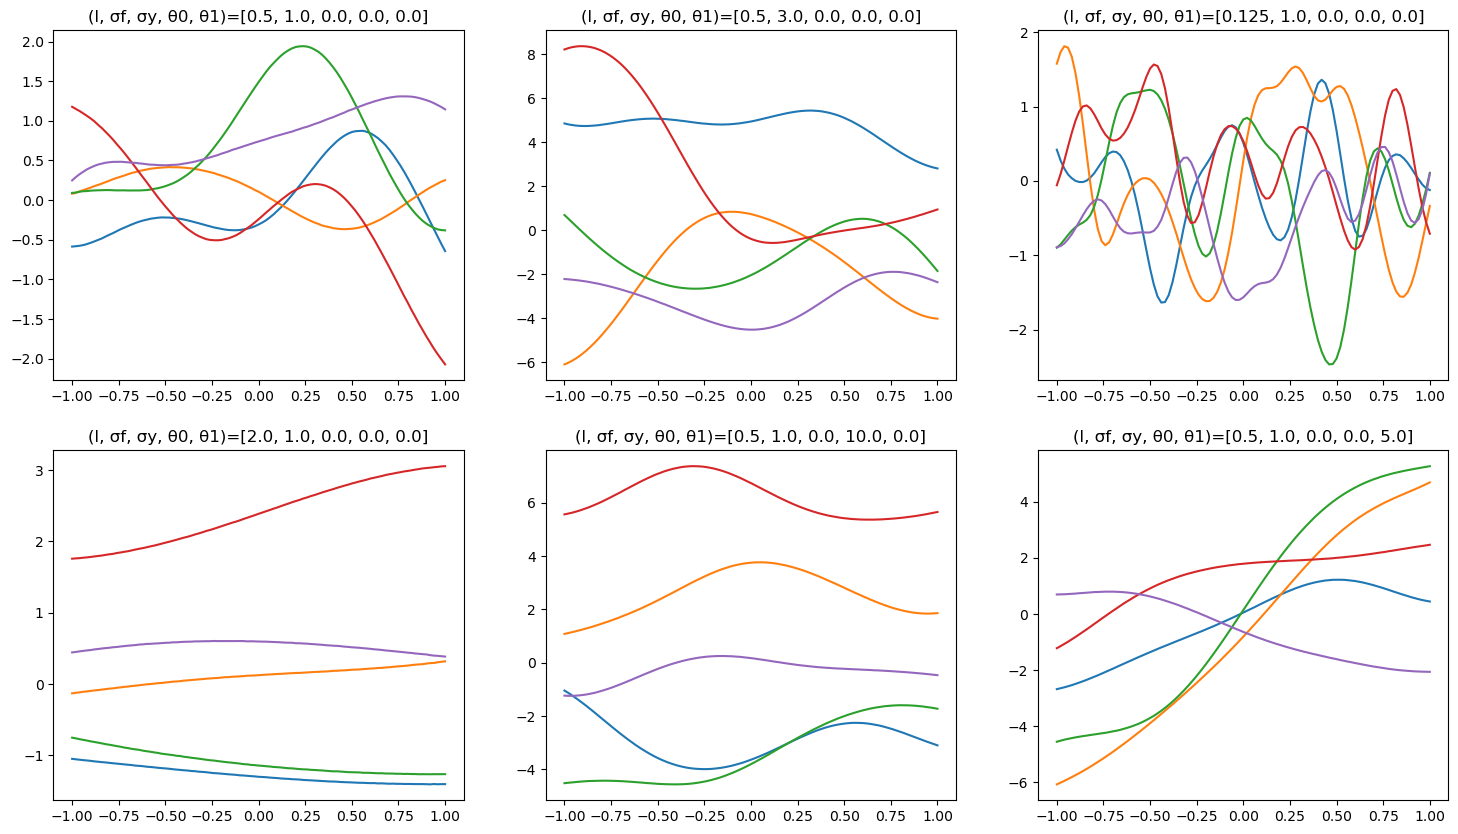

In [6]:
fig = figure(figsize=(18,10))
numplots = 5
cnt = 0
for i in 1:size(Thetas, 1)
    thetas = Thetas[i]
    mixkernel = MixtureKernel(thetas...)
    # prevent non-positive definite error
    K = covariancematrix(mixkernel, x) + 1e-6*Diagonal(ones(101))
    ys = rand(MvNormal(zeros(size(x, 1)), K), numplots)
    ax = fig.add_subplot(2,3,cnt+1)
    ax.plot(x, ys)
    ax.set_title("(l, σf, σy, θ0, θ1)=$thetas")
    cnt += 1
end

## Simulated Data

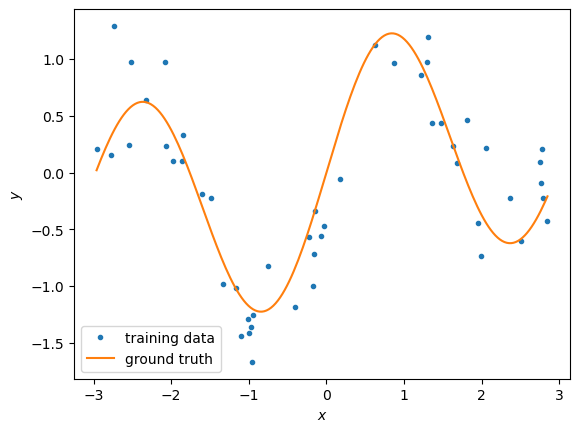

PyObject <matplotlib.legend.Legend object at 0x7f8810aa39d0>

In [7]:
Random.seed!(102);

truef(x) = sin(2*x) + 0.2*sin(x) + 0.1*x
N = 50
X = rand(Uniform(-3, 3), N)
ϵ = 0.3 * rand(Normal(), N)
y = truef.(X) .+ ϵ

Xplot = collect(range(minimum(X), maximum(X), length=200))
Xtest = Xplot

plot(X, y, ".", label="training data")
plot(Xplot, truef.(Xplot), label="ground truth")
xlabel(L"$x$")
ylabel(L"$y$")
legend()

## Predict with fixed hyperparameters

In [8]:
# length scale (l), vertical scale (σf), observation noise (σy), θ0, θ1
#σy = sqrt(1/3.0)
σy = 0.577
Thetas = [
    [0.5,   1.0, σy, 0.0, 0.0],
    [0.5,   3.0, σy, 0.0, 0.0],
    [0.125, 1.0, σy, 0.0, 0.0],
    [2.0,   1.0, σy, 0.0, 0.0],
    [0.5,   1.0, σy, 10.0, 0.0],
    [0.5,   1.0, σy, 0.0, 5.0]
]

6-element Array{Array{Float64,1},1}:
 [0.5, 1.0, 0.577, 0.0, 0.0]
 [0.5, 3.0, 0.577, 0.0, 0.0]
 [0.125, 1.0, 0.577, 0.0, 0.0]
 [2.0, 1.0, 0.577, 0.0, 0.0]
 [0.5, 1.0, 0.577, 10.0, 0.0]
 [0.5, 1.0, 0.577, 0.0, 5.0]

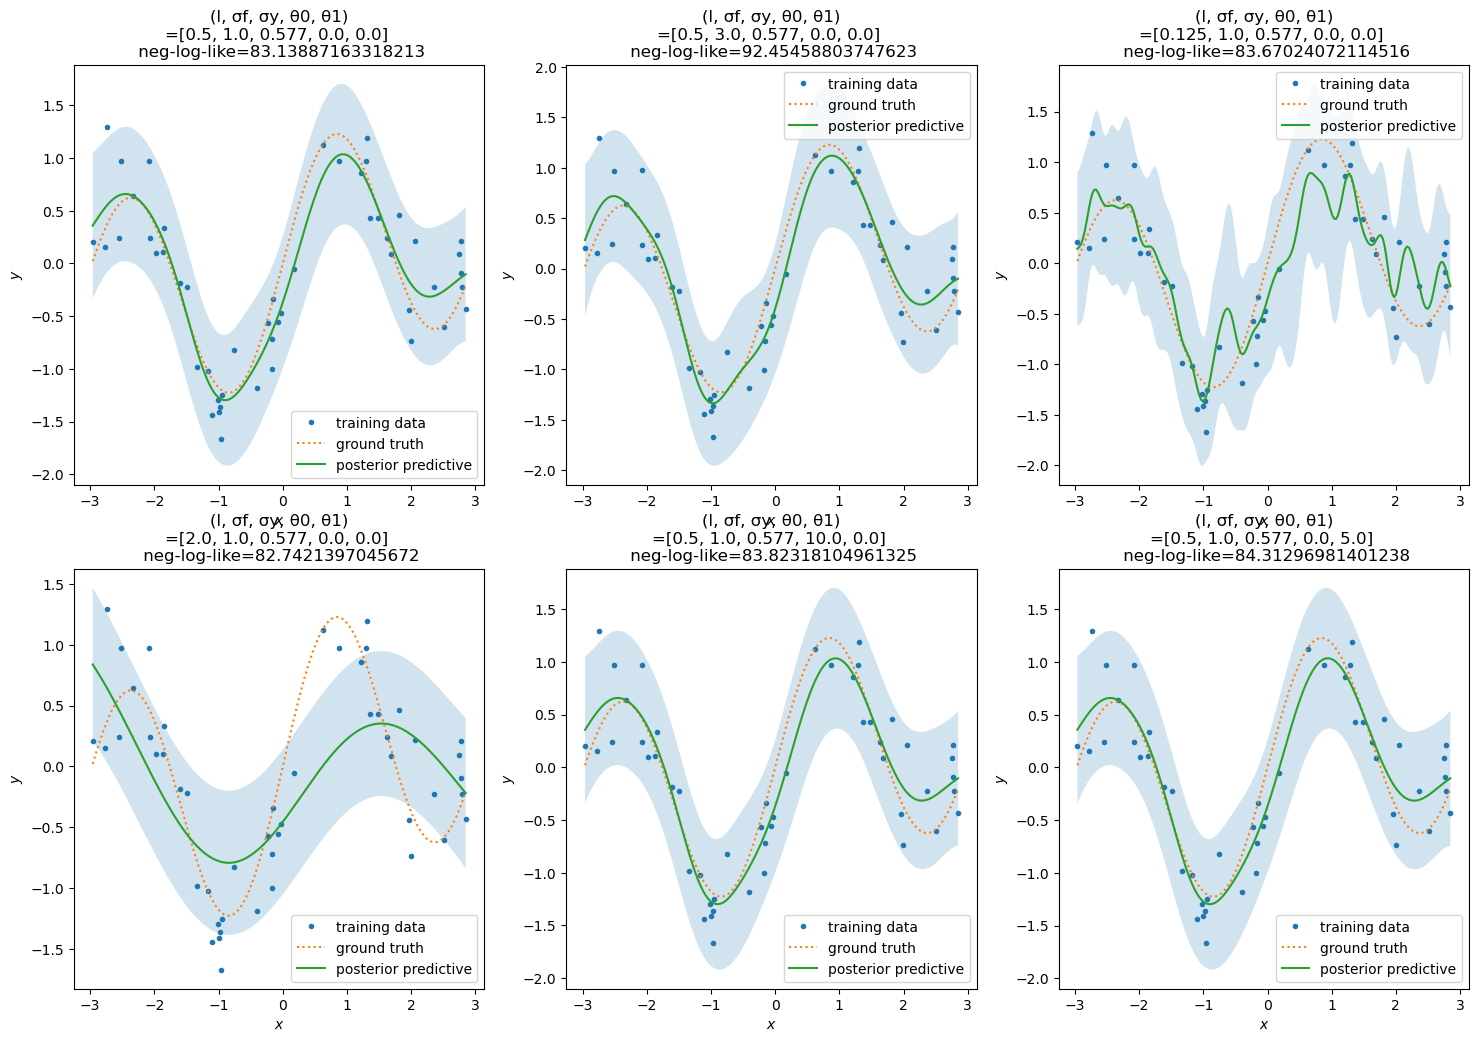

In [9]:
fig = figure(figsize=(18,12))
numplots = 5
cnt = 0
for i in 1:size(Thetas, 1)
    thetas = Thetas[i]
    mixkernel = MixtureKernel(thetas...)
    Ky = covariancematrix(mixkernel, X)
    μ, Σ = predict(mixkernel, X, y, Xtest)
    predstd = sqrt.(diag(Σ));
    nll = mixture_negloglike(X, y, thetas...)
    
    ax = fig.add_subplot(2,3,cnt+1)
    ax.plot(X, y, ".", label="training data")
    ax.plot(Xplot, truef.(Xplot), ":", label="ground truth")
    ax.plot(Xtest, μ, label= "posterior predictive")
    ax.fill_between(Xtest, μ+predstd, μ-predstd, alpha=0.2)

    xlabel(L"$x$")
    ylabel(L"$y$")
    legend()
    ax.set_title("(l, σf, σy, θ0, θ1)\n=$thetas \n neg-log-like=$nll")
    cnt += 1
end

## Regression (optimization of hyperparameters)

In [10]:
opt = optimize_sekernel(X, y)

 * Status: success

 * Candidate solution
    Final objective value:     2.452611e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    4
    f(x) calls:    52
    ∇f(x) calls:   52


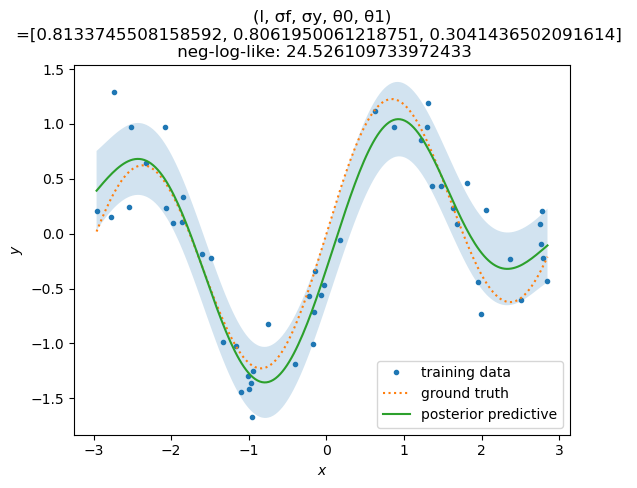

minimum(opt) = 24.52610973397244


PyObject Text(0.5, 1.0, '(l, σf, σy, θ0, θ1)\n=[0.8133745508158592, 0.8061950061218751, 0.3041436502091614] \n neg-log-like: 24.526109733972433')

In [11]:
params = Optim.minimizer(opt)

@show minimum(opt)

#@show thetas = [exp(param) for param in params]
thetas = params

mixkernel = SquaredExponentialKernel(thetas...)
Ky = covariancematrix(mixkernel, X)
μ, Σ = predict(mixkernel, X, y, Xtest)
predstd = sqrt.(diag(Σ));
nll = sqexp_negloglike(X, y, thetas...)

plot(X, y, ".", label="training data")
plot(Xplot, truef.(Xplot), ":", label="ground truth")
plot(Xtest, μ, label= "posterior predictive")
fill_between(Xtest, μ+predstd, μ-predstd, alpha=0.2)

xlabel(L"$x$")
ylabel(L"$y$")
legend()

title("(l, σf, σy, θ0, θ1)\n=$thetas \n neg-log-like: $nll")

## Optimization while passing the gradient function

First we make sure the analytical and autodiff gradients agree at a certain point

In [12]:
Random.seed!(102);
init_params = rand(3)
sekernel = SquaredExponentialKernel(exp.(init_params)...)

SquaredExponentialKernel(1.0379579261758287, 2.606578416604105, 2.444038760075165)

Analytical result

In [13]:
-logmarginalgradient(sekernel, X, y)

3-element Array{Float64,1}:
 -2.1926379904830684
  4.426457198507448
 44.037783883087705

Approximate gradient from `Zygote`

In [14]:
gradient(params -> sqexp_negloglike_log(X, y, params...), init_params)

((-2.192637990483069, 4.426457198507452, 44.037783883087705),)

In [15]:
@time optimize_sekernel(X, y)

  0.070863 seconds (13.46 k allocations: 64.334 MiB, 30.38% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     2.452611e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.20e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.81e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    52
    ∇f(x) calls:   52


In [16]:
@time optimize_sekernel(X, y, sqexp_gradient_autodiff!)

  0.458849 seconds (1.39 M allocations: 95.444 MiB, 4.15% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     2.452611e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.46e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.07e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.95e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    50
    ∇f(x) calls:   50


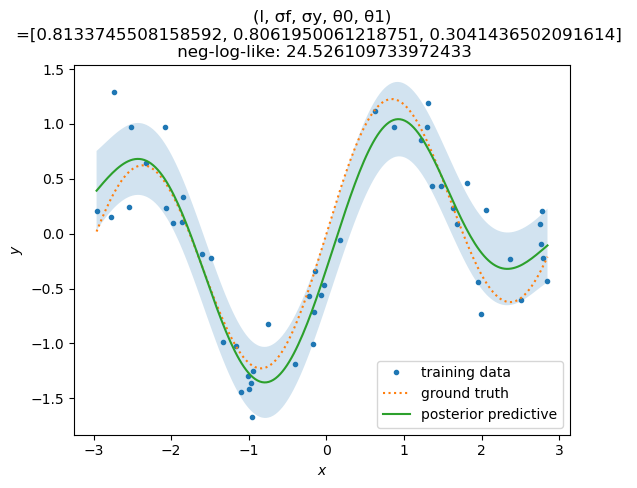

minimum(opt) = 24.52610973397244


PyObject Text(0.5, 1.0, '(l, σf, σy, θ0, θ1)\n=[0.8133745508158592, 0.8061950061218751, 0.3041436502091614] \n neg-log-like: 24.526109733972433')

In [17]:
params = Optim.minimizer(opt)

@show minimum(opt)

#@show thetas = [exp(param) for param in params]
thetas = params

mixkernel = SquaredExponentialKernel(thetas...)
Ky = covariancematrix(mixkernel, X)
μ, Σ = predict(mixkernel, X, y, Xtest)
predstd = sqrt.(diag(Σ));
nll = sqexp_negloglike(X, y, thetas...)

plot(X, y, ".", label="training data")
plot(Xplot, truef.(Xplot), ":", label="ground truth")
plot(Xtest, μ, label= "posterior predictive")
fill_between(Xtest, μ+predstd, μ-predstd, alpha=0.2)

xlabel(L"$x$")
ylabel(L"$y$")
legend()

title("(l, σf, σy, θ0, θ1)\n=$thetas \n neg-log-like: $nll")